In [31]:
import torch
import torch.nn as nn
import torch.distributions as d
from torch.distributions.relaxed_categorical import ExpRelaxedCategorical, RelaxedOneHotCategorical
import matplotlib.pyplot as plt

## Exploration

`torch.distributions.relaxed_categorical.RelaxedOneHotCategorical(temperature, probs=None, logits=None, validate_args=None)`

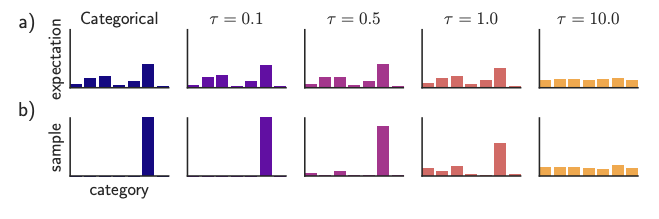

In [32]:
dist = RelaxedOneHotCategorical(torch.tensor([0.5]), probs=torch.tensor([0.1, 0.9, 0.3]))

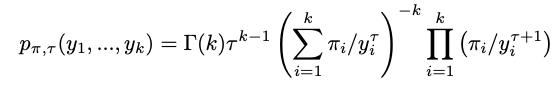

In [33]:
d.kl.kl_divergence(dist.base_dist._categorical, dist.base_dist._categorical)

tensor(0.)

In [34]:
from scipy.special import gamma
import numpy as np

In [35]:
# eq_prob = gamma(2) * 0.5 * (0.1 / sample_np[0] ** 0.5 + 0.9 / sample_np[1] ** 0.5) ** (-2) * (
#     (0.1 / sample_np[0] ** (0.5+1)) * (0.9 / sample_np[1] ** (0.5+1))
# )
# np.log(eq_prob)

In [36]:
samples = dist.sample(sample_shape=(100,))

In [37]:
dist.log_prob(samples)

tensor([ 6.5120,  4.3333,  8.1540,  6.7686, -0.1837,  5.9645,  5.3396,  9.4253,
         2.9194,  4.3963,  3.9607,  0.6699, 10.2340,  2.0422,  3.3959,  4.0863,
         6.3384,  0.9320,  6.1482,  3.8157,  4.1635,  0.8720,  0.7554,  0.2262,
         0.0961,  6.4464,  4.3895,  4.6840,  2.9148,  3.6017,  3.4633, -1.4812,
         7.8641,  4.4387,  2.9186,  5.3221,  0.3567, 21.5124,  1.2331,  5.6414,
        -1.0404,  8.1169,  0.7665,  4.7446,  4.5926,  1.4919,  5.0431, -1.2612,
         7.0115, -0.5231,  9.4238,  3.2843,  3.5627, 10.4187,  7.9862,  4.9185,
         8.8816, -0.9284,  3.3093, -0.0834, -0.5194,  9.6087,  1.5290,  0.2831,
         2.1182, 14.2482,  1.3832,  3.8463,  2.9612,  3.3721,  2.2644, -1.1874,
        -0.0692,  1.9852,  0.7058,  9.1394,  2.5346,  5.8309,  2.2014,  6.3010,
         3.0592,  5.1042,  8.0219,  0.6578,  6.5834,  5.4326, 13.4571,  0.6545,
        -0.5599,  4.1276,  4.5486, -1.8416, -0.0515, 10.5896, -0.2154,  4.8685,
         3.9954,  2.9562, 14.3570,  4.38

In [38]:
dist = d.Categorical(probs=torch.tensor([0.5, 0.5]))

In [39]:
samples = dist.sample(sample_shape=(10, ))
samples

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])

In [40]:
dist.log_prob(samples)

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])

## Distributions

In [1319]:
import torch.distributions as d

OneHotCat = d.OneHotCategorical
RelaxedOneHotCat = d.relaxed_categorical.RelaxedOneHotCategorical

Ind = d.Independent
Normal = d.Normal

CB = d.ContinuousBernoulli

## Generative model

### Module for p(y)

In [1916]:
class p_y_class(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.y_dim = y_dim
        self.logits = nn.Parameter(torch.ones(y_dim))
        
    def forward(self):
        return OneHotCat(logits=self.logits)

### Module for p(z|y)

In [1946]:
class p_z_given_y_class(nn.Module):
    
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.mus = nn.Linear(y_dim, z_dim)
        self.log_sigmas = nn.Linear(y_dim, z_dim)
        
    def forward(self, ys):
        return Ind(Normal(self.mus(ys), self.log_sigmas(ys).exp()), 1)

### Module for p(x|z)

In [1947]:
class p_x_given_z_class(nn.Module):

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.shared = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.mus = nn.Linear(64, x_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(64, x_dim),
            nn.Softplus()
        )
        
    def forward(self, zs):
        temp = self.shared(zs)
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

## Approximate posterior

### Module for q(y|x)

In [1948]:
class q_y_given_x_class(nn.Module):
    
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layers = nn.Sequential(
            nn.Linear(x_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dim)
        )
        
    def forward(self, xs):
        return OneHotCat(logits=self.layers(xs))

### Module for q(z|x, y)

In [1920]:
class q_z_given_x_y_class(nn.Module):

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            nn.Linear(x_dim + y_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.mus = nn.Linear(64, z_dim)
        self.log_sigmas = nn.Linear(64, z_dim)

    def forward(self, xs, ys):
        temp = self.shared(torch.cat([xs, ys], dim=1))
        return Ind(Normal(self.mus(temp), self.log_sigmas(temp).exp()), 1)

## AEVB

In [1921]:
import itertools
import torch.optim as optim

In [1922]:
torch.tensor([1, 2, 3, 4, 5, 1, 2 ,3 ,4, 5]).reshape(2, 5).T

tensor([[1, 1],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5]])

In [1949]:
class AEVB(nn.Module):
    
    def __init__(self, x_dim, y_dim, z_dim, lr=1e-3):
        
        super().__init__()
        
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        # generative model
        
        self.p_y = p_y_class(y_dim)
        self.p_z_given_y = p_z_given_y_class(y_dim, z_dim)
        self.p_x_given_z = p_x_given_z_class(x_dim, z_dim)

        # approximate posterior
        
        self.q_y_given_x = q_y_given_x_class(x_dim, y_dim)
        self.q_z_given_x_y = q_z_given_x_y_class(x_dim, y_dim, z_dim)
        
        # optimizers
        
        self.opt = optim.Adam(
            self.parameters(),
            lr=lr
        )
        
    def step(self, xs, train, debug=False):

        probs = self.q_y_given_x(xs).mean
        
        if debug:
            assert probs.sum(dim=1).mean() == 1
        
        if debug:
            print(probs)
            print(probs.shape)

        bs = xs.size(0)
    
        ys = torch.eye(self.y_dim)[torch.tensor(range(self.y_dim)).repeat_interleave(bs)]
        if debug:
            print("ys.shape: ", ys.shape)
        xs = xs.repeat(self.y_dim, 1)
        if debug:
            print("xs.shape: ", ys.shape)
        post_over_zs = self.q_z_given_x_y(xs, ys)
        zs = post_over_zs.rsample()
        fs = self.p_x_given_z(zs).log_prob(xs) \
             + self.p_y().log_prob(ys) \
             - self.q_y_given_x(xs).log_prob(ys) \
             - d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys))
        if debug:
            print(self.p_x_given_z(zs).log_prob(xs).shape)
            print(self.p_y().log_prob(ys).shape)
            print(self.q_y_given_x(xs).log_prob(ys).shape)
            print(d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys)).shape)
        fs = fs.reshape(self.y_dim, bs).T
        fs = (probs * fs).sum(dim=1)
        
        estimated_elbo = fs.mean()
        loss = - estimated_elbo
        
        if train:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        
        return float(estimated_elbo)
    
    def predict_cluster(self, xs):
        with torch.no_grad():
            return self.q_y_given_x(xs).mean.argmax(dim=1)
    
    def generate(self, n, mode):
        with torch.no_grad():
            ys = self.p_y().sample((n, ))
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs
    
    def generate_from_cluster(self, n, cluster_index, mode):
        with torch.no_grad():
            ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs

In [1950]:
aevb = AEVB(x_dim=2, y_dim=5, z_dim=2)

In [1951]:
data = torch.randn(100, 2).clip(0, 1)

In [1952]:
aevb.step(data, train=True)

-2.3005690574645996

## Data

In [1953]:
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [1954]:
import pandas as pd
import numpy as np

In [1955]:
x_train = pd.read_csv("painted_data.csv")[["x", "y"]].to_numpy()
x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
y_train = []
for class_label in pd.read_csv("painted_data.csv")[["Class"]].to_numpy().flatten():
    y_train.append(int(class_label[1]) - 1)
y_train = np.array(y_train)

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=100)

x_test_torch = torch.from_numpy(x_train).float()
y_test = y_train

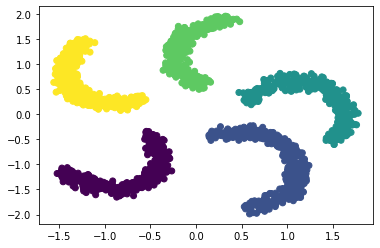

In [1956]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

## Training

In [1957]:
from scipy.optimize import linear_sum_assignment
def cluster_acc(Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size

In [1958]:
cluster_acc([1, 2, 3], [3, 2, 1])

1.0

In [1959]:
from tqdm import tqdm

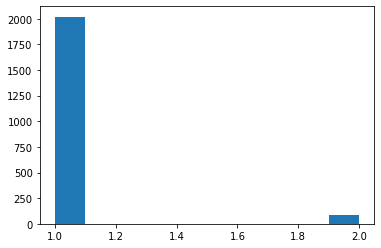

In [1960]:
aevb = AEVB(x_dim=2, y_dim=5, z_dim=2)
# aevb.apply(init_weights)
plt.hist(aevb.predict_cluster(x_test_torch).numpy())
plt.show()

In [1961]:
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [1967]:
aevb = AEVB(x_dim=2, y_dim=3, z_dim=2)
# aevb.apply(init_weights)

test_elbos = []

test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
print(test_acc)

for epoch in range(1000):
    
    print(epoch)
    
    aevb.train()
    
    for (xb, ) in train_dl:
        aevb.step(xb, train=True)
        
    aevb.eval()
    
    test_elbo = aevb.step(x_test_torch, train=False)
    test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
    
    print(test_elbo, test_acc)
    
with open("test_elbos", "wb") as fp:
    pickle.dump(test_elbos, fp)

0.23823109843081314
0
-3.175743818283081 0.23823109843081314
1
-2.978827714920044 0.4013314312886353
2
-2.8787529468536377 0.4617213504517356
3
-2.855032444000244 0.43889681407513076
4
-2.8521337509155273 0.43842130290061815
5
-2.8508267402648926 0.4427009034712316
6
-2.8452768325805664 0.4427009034712316
7
-2.846327304840088 0.444602948169282
8
-2.8434202671051025 0.4455539705183072
9
-2.845086097717285 0.4526866381359962
10
-2.8427722454071045 0.4498335710889206
11
-2.8413867950439453 0.4526866381359962
12
-2.845370292663574 0.4498335710889206
13
-2.844500780105591 0.4526866381359962
14
-2.8422703742980957 0.4526866381359962
15
-2.842198610305786 0.4526866381359962
16
-2.845252752304077 0.4526866381359962
17
-2.839272975921631 0.4526866381359962
18
-2.844032049179077 0.4526866381359962
19
-2.8439862728118896 0.4526866381359962
20
-2.8442447185516357 0.4526866381359962
21
-2.842226266860962 0.4526866381359962
22
-2.8438198566436768 0.4526866381359962
23
-2.8399851322174072 0.452686638

-2.8416831493377686 0.3547313361864004
199
-2.8414173126220703 0.4526866381359962
200
-2.841407537460327 0.23823109843081314
201
-2.841139554977417 0.3067047075606277
202
-2.8411080837249756 0.4526866381359962
203
-2.8412373065948486 0.23823109843081314
204
-2.841600179672241 0.23823109843081314
205
-2.841163158416748 0.4526866381359962
206
-2.8417842388153076 0.437470280551593
207
-2.8426382541656494 0.23823109843081314
208
-2.8428096771240234 0.4526866381359962
209
-2.8432207107543945 0.4526866381359962
210
-2.8442838191986084 0.23823109843081314
211
-2.845194101333618 0.3333333333333333
212
-2.845431327819824 0.4526866381359962
213
-2.846120595932007 0.23823109843081314
214
-2.846079111099243 0.23823109843081314
215
-2.8457388877868652 0.3357108892058963
216
-2.843789577484131 0.23823109843081314
217
-2.843240737915039 0.23823109843081314
218
-2.84309983253479 0.23823109843081314
219
-2.8431127071380615 0.2344270090347123
220
-2.8426871299743652 0.23823109843081314
221
-2.8417987823

KeyboardInterrupt: 

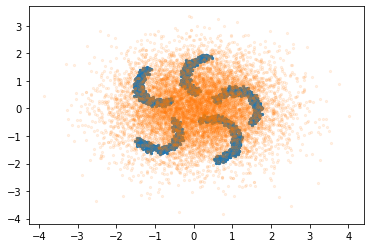

In [1963]:
plt.scatter(x_train[:,0], x_train[:,1], s=5)
gens = aevb.generate(n=10000, mode="sample").numpy()
plt.scatter(gens[:,0], gens[:,1], s=5, alpha=0.1)
plt.show()

## Reconstruction

In [1964]:
import matplotlib.pyplot as plt

RuntimeError: shape '[28, 28]' is invalid for input of size 2

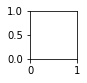

In [1965]:
torch.manual_seed(10)
gens = aevb.generate(n=30, mode="mean").detach()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)

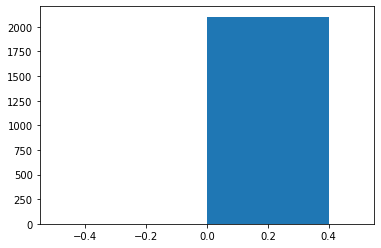

In [1966]:
plt.hist(aevb.predict_cluster(x_test_torch).numpy(), width=0.4)
plt.show()

## Generation per category

In [1806]:
def generate_from_cluster(self, n, cluster_index, mode):
    with torch.no_grad():
        ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
        zs = self.p_z_given_y(ys).sample()
        if mode == "mean":
            xs = self.p_x_given_z(zs).mean
        elif mode == "sample":
            xs = self.p_x_given_z(zs).sample()
        elif mode == "param":
            xs = self.p_x_given_z.lambdas(zs)
        return xs

RuntimeError: shape '[28, 28]' is invalid for input of size 2

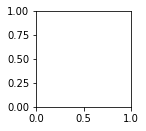

In [1807]:
torch.manual_seed(42)
plt.figure(figsize=(20, 6))
for row_index in range(3):
    gens = generate_from_cluster(aevb, n=10, cluster_index=row_index, mode="sample").detach()
    for col_index in range(10):
        plt.subplot(3, 10, row_index * 10 + col_index + 1)
        plt.imshow(gens[col_index].reshape(28, 28), cmap="viridis")
        plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)